ShufflingFedAvg1.0_M1000,10_K5_R20000,100_cnn_cifar10_shard1_sgd0.1,0.0,0.0_exp1.0_b16_seed0_clip10


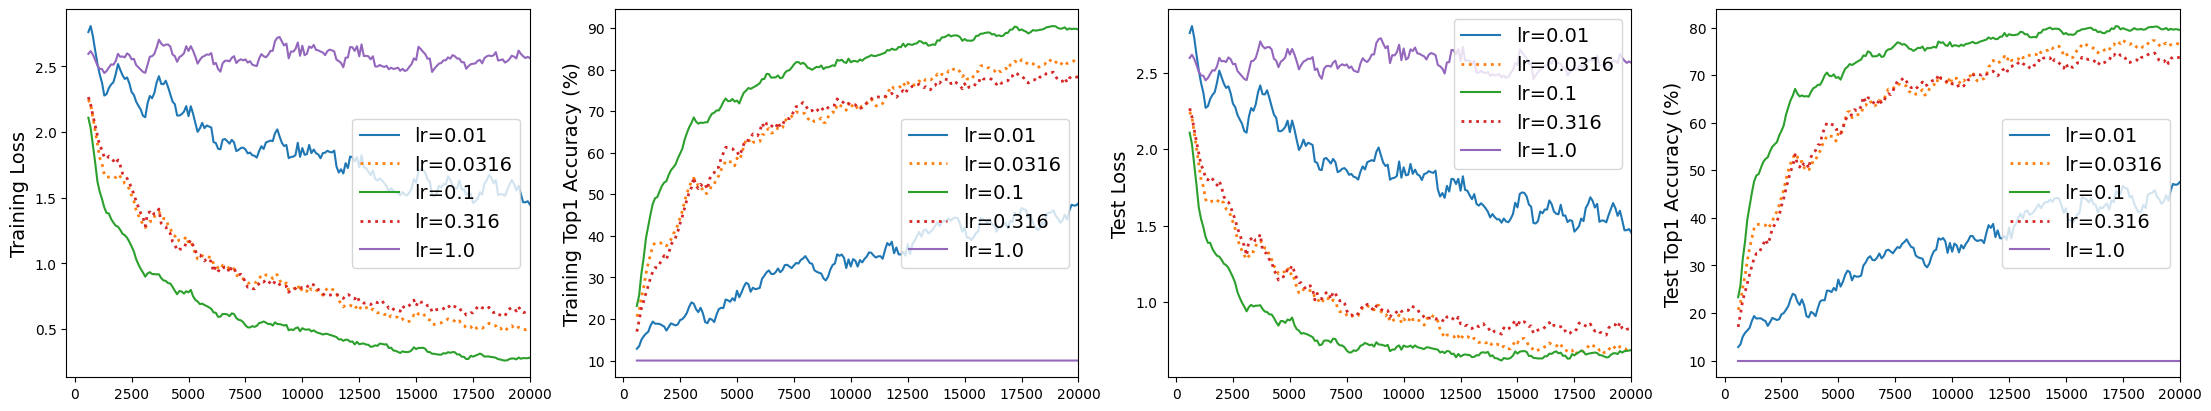

In [ ]:
import sys 
sys.path.append("/home/moon/data/github/ordering/")

import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sim.utils.record_utils import read_fromcsv
from plots.plot_utils import grid_search, moving_average, save_fig_timestamp, get_existing_files, YLABELS
import itertools
from types import SimpleNamespace


args, search_setup, path = None, None, None

def get_substring(input_string, pattern=r"sgd[\d\.]+"):
    match = re.search(pattern, input_string)
    return match.group()

def plot_curve(ax, files, setup, path):
    global args
    for i,file in enumerate(files):
        df = read_fromcsv(file, path)
        #step = df['round'].values[1] - df['round'].values[0]
        x = df['round'].values
        y = df.iloc[:, setup['y']].values

        if setup['out'] == 1:
            out = df  
            #out = out[df['round'] <= 5000]
            out = out.iloc[:, setup['y']].values[-10:]
            #print('{:>6}:'.format('('+str(Algs[i])+')'), end=' ')
            if setup['y'] == 1 or setup['y'] == 4:
                print('{:>9.4f}'.format(out.mean(axis=0)), end=' ')
            else:
                print('{:>9.2f}'.format(out.mean(axis=0)), end=' ')
        
        if setup['smooth'] == 1:
            window_size = 6
            y_smooth = moving_average(y, window_size)
            # adjust the length of the smooth data
            # discard `len(data)- (len(data)-len(windows)+1)=len(windows)-1` data points
            x_smooth = x[len(x)-len(y_smooth):]
            x,y = x_smooth, y_smooth
            
        if any(lr in file for lr in ["sgd0.001", "sgd0.01", "sgd0.1", "sgd1.0", "sgd10.0"]):
            linestyle = '-'
            ax.plot(x, y, lw=1.5, linestyle=linestyle, label="lr={}".format(get_substring(file)[3:]))
        else:
            linestyle = ':'
            ax.plot(x, y, lw=2, linestyle=linestyle, label="lr={}".format(get_substring(file)[3:])) # dashes=[3, 3]
        ax.set_xlim(xmax=args.R)
    
    if setup['y'] == 1 or setup['y'] == 4:
        pass
        #ax.set_yscale('log')
        # if max(y) > 10:
        #     ax.set_ylim(ymax=y[30], ymin=0)
    ax.legend(fontsize=14)
    ax.set_ylabel(YLABELS[setup['y']], fontsize=14)
    #ax.grid()


def plot_diff(ax, files, setup, path):
    
    y_contents = []
    for file in files:
        df = read_fromcsv(file, path)
        #step = df['round'].values[1] - df['round'].values[0]
        x_axis = df['round'].values
        y_content = df.iloc[:, setup['y']].values
        y_contents.append(y_content)

    diff = y_contents[1] - y_contents[0]
    #print(diff[-10:].mean())
    ax.bar(x_axis, diff, width=20, color='C0', alpha=0.8)




def filter_func(file, curr_value):
    if curr_value <= 10.0:
        return 1
    else:
        return 0

def filter_func2(file, curr_value):
    return 0

def cmp_func(curr_value, best_value):
    if best_value == 0:
        return 1
    if curr_value > best_value:
        return 1
    
def cmp_func2(curr_value, best_value):
    if best_value == 0:
        return 1
    if curr_value < best_value:
        return 1

def main():
    global args, search_setup, path

    args2 = {
    #'global_lr': [1.0],
    'M': [args.M],
    'P': [args.P],
    'K': [args.K],
    'R': [args.R],
    'eval_every': [args.eval_every],
    'model': [args.model],
    'dataset': [args.dataset],
    'partition': ['shard1'],
    #'partition': ['iid'],
    #'exdir2': [args.exdir2],
    #'lr': [0.00316, 0.01, 0.0316, 0.1, 0.316],
    #'lr': [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0],
    'lr': [0.01, 0.0316, 0.1, 0.316, 1.0],
    'momentum': [args.momentum],
    'weight_decay': [args.weight_decay],
    'lr_scheduler': [args.lr_scheduler],
    'lr_decay': [args.lr_decay],
    'minibatch': [args.minibatch],
    'seed': [args.seed],
    'clip': [10],
    }
    end = args.R # grid search

    #pattern2 = "ShufflingFedAvg1.0_M{},{}_K{}_R{},{}_{}_{}_{}{},{}_sgd{},{},{}_{}{}_b{}_seed{}_clip{}"
    pattern2 = "ShufflingFedAvg1.0_M{},{}_K{}_R{},{}_{}_{}_{}_sgd{},{},{}_{}{}_b{}_seed{}_clip{}"

    files = []
    combinations = itertools.product(*tuple(args2.values()))
    for i in combinations:
        file = pattern2.format(*i)
        files.append(file)

    files = get_existing_files(files, path)
    fig, axs = plt.subplots(1, 4, figsize=(22, 4), constrained_layout=True)
    for i in range(4):
        plot_curve(axs[i], files, setup={'out': 0, "smooth": 1, 'y': [1, 2, 4, 5][i], 'label': args2['lr']}, path= path)
    #fig.tight_layout()
    save_fig_timestamp(fig)
    
    best_file2 = grid_search(pattern2, args=args2, setup={'metric': 5, 'select': 10, 'end': end, 'filter_func': filter_func, 'cmp_func': cmp_func}, path=path)


if __name__ == '__main__':
    args = {
    'M': 1000,
    'P': 10,
    'K': 5,
    'R': 20000,
    'eval_every': 100,
    'model': 'cnn',
    'dataset': 'cifar10',
    'exdir': 1,
    'exdir2': 100.0,
    #'lr': [0.00316, 0.01, 0.0316, 0.1, 0.316],
    #'lr': [0.01, 0.1],
    'momentum': 0.0,
    'weight_decay': 0.0,
    'lr_scheduler': 'exp',
    'lr_decay': '1.0',
    'minibatch': 16,
    'seed': 0,
    }
    
    args = SimpleNamespace(**args)
    path = f'/home/moon/data/github/ordering/save/fl/'
    main()